In [7]:
#This project studies the average rainfall from January 1, 1982 to June 30, 2021 in Singapore. 
#We will be first getting the API from https://data.gov.sg website
#Next create JSON file with all the data from the API
#Use Spark to analyze the JSON file

In [2]:
import requests
import json

#create nice format for JSON file 
def jprint(obj):
    # create a formatted string of the Python JSON object
    text = json.dumps(obj, sort_keys=True, indent=4)
    return text

#write to new file created , need be in the format as seen in ### below 

def write_to_file():
    output_file = "/Users/Vaahsan/SparkCourse/SingaporeRainFall.json"
    #get the JSON file here
    response = requests.get(
        "https://data.gov.sg/api/action/datastore_search?resource_id=df4d391e-6950-4fc6-80cd-c9b9ef6354fe&limit=100000000000000000")
    with open(output_file, 'a') as f:
        #write the text printed from jprint nicely to a file 
        f.write(jprint(response.json()["result"]["records"]))  # Creating a JSON String from a dict object
        f.write("\n")  # Appending new line at the end of the JSON record
    return output_file

#Note: Spark accepts JSON data in the new-line delimited JSON Lines format, which basically means the JSON file must meet the below 3 requirements,
#Each Line of the file is a JSON Record
#Line Separator must be ‘\n’ or ‘\r\n’
#Data must be UTF-8 Encoded

write_to_file()

'/Users/Vaahsan/SparkCourse/SingaporeRainFall.json'

In [3]:

#initialize pyspark session need do this for Jupyter Notebook only
import findspark
findspark.init()

import requests
import  json
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql.functions import to_date,col,date_format,year,month

spark = SparkSession.builder.appName("APIs").getOrCreate()

#spark.read only accepts (1) RDD, (2) List , (3) File Path
df = spark.read.option("multiline","true").json("file:///Users/Vaahsan/SparkCourse/SingaporeRainFall.json")

#convert to correct data type i.e datetime
#multplie conversion in 1 line
df2 = df.withColumn("year", year(col("month"))).withColumn("month",month(col("month")))

#convert rainfall into integer using cast method on col
df2 = df2.withColumn("maximum_rainfall_in_a_day",col("maximum_rainfall_in_a_day").cast(IntegerType()))

df2.show()

+---+-------------------------+-----+----+
|_id|maximum_rainfall_in_a_day|month|year|
+---+-------------------------+-----+----+
|  1|                       36|    1|1982|
|  2|                        9|    2|1982|
|  3|                       61|    3|1982|
|  4|                       45|    4|1982|
|  5|                       33|    5|1982|
|  6|                       20|    6|1982|
|  7|                       17|    7|1982|
|  8|                       57|    8|1982|
|  9|                       18|    9|1982|
| 10|                       10|   10|1982|
| 11|                       39|   11|1982|
| 12|                      109|   12|1982|
| 13|                       43|    1|1983|
| 14|                        5|    2|1983|
| 15|                       18|    3|1983|
| 16|                       21|    4|1983|
| 17|                       32|    5|1983|
| 18|                       27|    6|1983|
| 19|                       55|    7|1983|
| 20|                      181|    8|1983|
+---+------

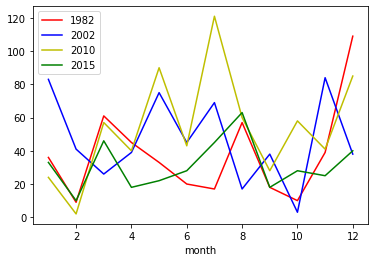

In [5]:


import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#filter multiple conditions with | to specific years wanted 
df3 = df2.filter((col("year") == "1982") | (col("year") == "2015")| (col("year") == "2002")|(col("year") == "2010"))

#must convert Spark DF to Pandas DF to use the plot
df3p = df3.toPandas()

ax = plt.gca()

#just filtering the Pandas DF to plot 
df3p[df3p["year"] ==1982].plot("month" , y = "maximum_rainfall_in_a_day", label = "1982", color="r" , ax = ax)
df3p[df3p["year"] ==2002].plot("month" , y = "maximum_rainfall_in_a_day", label = "2002", color="b",  ax = ax)
df3p[df3p["year"] ==2010].plot("month" , y = "maximum_rainfall_in_a_day", label = "2010", color="y", ax = ax)
df3p[df3p["year"] ==2015].plot("month" , y = "maximum_rainfall_in_a_day", label = "2015", color="g", ax = ax)

#Overview 10 years frequency Weather Comparison

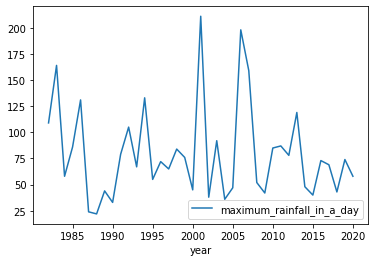

In [8]:

import matplotlib.pyplot as plt
df4 = df2.filter((col("month") == "12"))
df4p1 = df4.toPandas()
df4p1.plot(x = "year" , y = "maximum_rainfall_in_a_day")

#Only Decembers rainfall

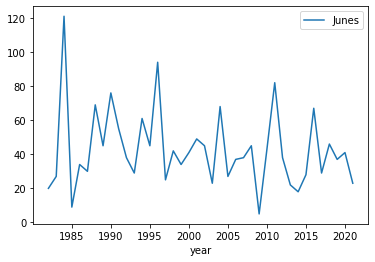

In [9]:
import matplotlib.pyplot as plt
df4 = df2.filter((col("month") == "6"))
df4p2 = df4.toPandas()
df4p2.plot(x = "year" , y = "maximum_rainfall_in_a_day" , label = "Junes")

#Only June Rainfalls

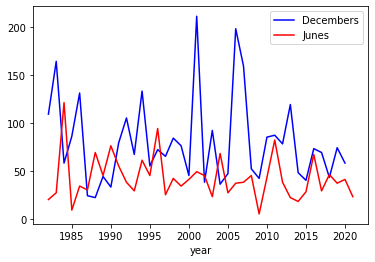

In [16]:
ax = plt.gca()

#just filtering the Pandas DF to plot 
df4p1.plot("year" , y = "maximum_rainfall_in_a_day", label = "Decembers", color="b" , ax = ax)
df4p2.plot("year" , y = "maximum_rainfall_in_a_day", label = "Junes", color="r" , ax = ax)

#Overalaying December and June rainfalls,we can see the year end weather is definitely 'wetter' compared to mid of the year

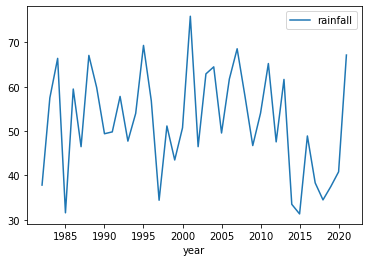

In [181]:
#average rainfall per year from 1985 to 2020

df5 = df2.groupBy("year").avg("maximum_rainfall_in_a_day").sort(col("year").desc())


df5p = df5.toPandas()

df5p.plot(x="year",y="avg(maximum_rainfall_in_a_day)", label = "rainfall")


#We can see the second driest year in Singapore is being 2015.Reason is attributed mainly 
#due to higher than usual haze (deforestation from Indonesia by means of burning) 
#and also El Nino event.

#http://www.weather.gov.sg/wp-content/uploads/2016/03/Annual-Climate-Assessment-Report-2015.pdf


In [193]:
#just for testing mlib 
#silly use mlib to predict weather for a particular month , regardless of year 
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorAssembler

#like a function that takes in a set of pre-defined columns and outputs them as featyres
assembler = VectorAssembler().setInputCols(["maximum_rainfall_in_a_day","month"]).setOutputCol("features")

#implement the function on your dataframe
df2x = assembler.transform(df2).select("maximum_rainfall_in_a_day","features")

#split data set into portion ,1 for trainig the other for predicting 
train = df2x.randomSplit([0.5,0.5])
trainDF = train[0]
DF = train[1]

#set up your model , see what ML model want to use
dt = DecisionTreeRegressor().setFeaturesCol("features").setLabelCol("maximum_rainfall_in_a_day")
#train model first
model = dt.fit(trainDF)


#predict it 
fullPredictions = model.transform(DF).show()


+-------------------------+-----------+----------+
|maximum_rainfall_in_a_day|   features|prediction|
+-------------------------+-----------+----------+
|                        0|  [0.0,2.0]|      3.25|
|                        2|  [2.0,3.0]|       5.0|
|                        3|  [3.0,8.0]|       5.0|
|                        3| [3.0,10.0]|       5.0|
|                        5| [5.0,10.0]|       5.0|
|                        6|  [6.0,7.0]|       5.0|
|                        7|  [7.0,2.0]|      3.25|
|                        9|  [9.0,2.0]|     16.95|
|                        9|  [9.0,6.0]|     16.95|
|                       10| [10.0,7.0]|     16.95|
|                       10|[10.0,10.0]|     16.95|
|                       11| [11.0,9.0]|     16.95|
|                       12| [12.0,4.0]|     16.95|
|                       13| [13.0,1.0]|     16.95|
|                       13| [13.0,2.0]|     16.95|
|                       13| [13.0,2.0]|     16.95|
|                       13| [13